# Lab 12b: LSTM-based RNN fo Stock Price Prediction (Multiple Indicators) 

In this lab, we will learn how to build an LSTM-based Recurrent Neural Network (RNN) to predict Google stock price step by step using **multiple indicators**. We are given Google stock price from January 2012 to December 2017. 
 - The task is to predict the trend of the stock price for 01-06 2018. 
 - The goal is to predict the **close price** of the given date from test data

### 1. Import Library

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### 2. Data review & processing

### 2.1 Read data (train and test)

In [3]:
stock_data = pd.read_csv("/content/gdrive/My Drive/Training/test/Google_Stock_Price_Train.csv")
test_data = pd.read_csv("/content/gdrive/My Drive/Training/test/Google_Stock_Price_Test.csv")

### 2.2 Data Exploration

In [4]:
stock_data.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
stock_data.tail()

,Date,Open,High,Low,Close,Volume
1504,22/12/2017,1061.109985,1064.199951,1059.439941,1060.119995,755100
1505,26/12/2017,1058.069946,1060.119995,1050.199951,1056.73999,760600
1506,27/12/2017,1057.390015,1058.369995,1048.050049,1049.369995,1271900
1507,28/12/2017,1051.599976,1054.750000,1044.770020,1048.140015,837100
1508,29/12/2017,1046.719971,1049.699951,1044.900024,1046.400024,887500


In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1509 non-null   object 
 1   Open    1509 non-null   float64
 2   High    1509 non-null   float64
 3   Low     1509 non-null   float64
 4   Close   1509 non-null   object 
 5   Volume  1509 non-null   object 
dtypes: float64(3), object(3)
memory usage: 70.9+ KB


From here we can see our data has 6 columns:
* **Date**: The date of recorded data
* **Open**: The price when stock market open
* **High**: The highest price price of date
* **Low**: The lowest price point of date
* **Volumn**: Total Sale of stock on that date

In [7]:
stock_data['Close'] = stock_data['Close'].apply(lambda x: float(x.replace(',', '')))
stock_data['Volume'] = stock_data['Volume'].apply(lambda x: float(x.replace(',', '')))

In [8]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1509 non-null   object 
 1   Open    1509 non-null   float64
 2   High    1509 non-null   float64
 3   Low     1509 non-null   float64
 4   Close   1509 non-null   float64
 5   Volume  1509 non-null   float64
dtypes: float64(5), object(1)
memory usage: 70.9+ KB


In [9]:
stock_data.sample(5)

,Date,Open,High,Low,Close,Volume
141,7/25/2012,303.020000,305.540000,301.550000,606.330000,3659600.0
1138,7/13/2016,723.620000,724.000000,716.850000,716.980000,935900.0
181,9/20/2012,360.880000,364.320000,359.260000,726.130000,5836500.0
1364,06/06/2017,983.159973,988.250000,975.140015,976.570007,1814600.0
1383,03/07/2017,912.179993,913.940002,894.789978,898.700012,1709800.0


### 3.3 Data Visualization

#### 3.3.1 Plot the Open price

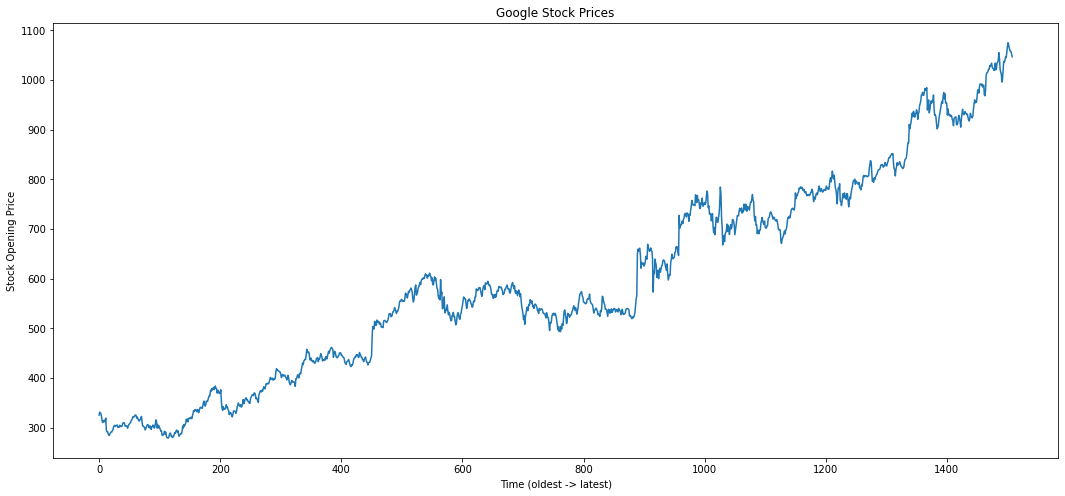

In [10]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Open'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Opening Price")
plt.show()

#### 3.3.2 Plot the High price

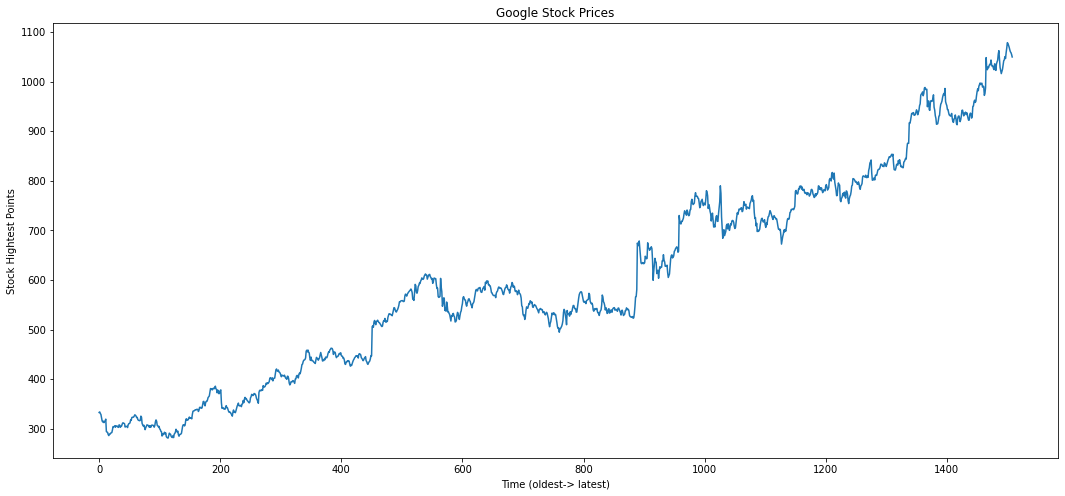

In [11]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['High'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("Stock Hightest Points")
plt.show()

#### 3.3.3 Plot the Low price

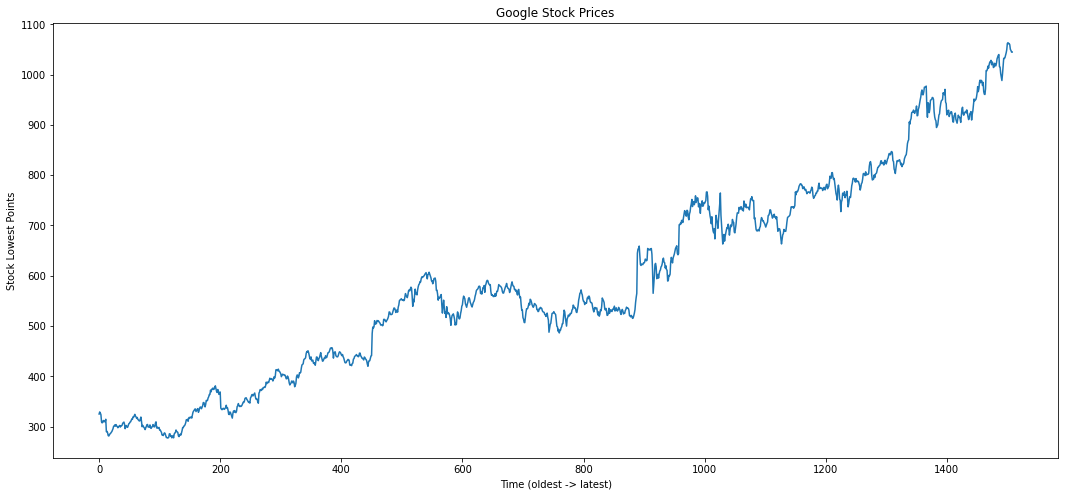

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Low'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Points")
plt.show()

### 3.4 Select feature
 - Select Open, High, Low, Volumn and Close columns. 
 - Put Close column to the last one as the target. 

In [13]:
input_feature = stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

In [14]:
input_data.shape

(1509, 5)

### 3.5 Normalize data
Normalize the data to between 0 and 1

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
# input_data[:,:] = scaler.fit_transform(input_data[:,:])
input_data = scaler.fit_transform(input_data)

In [16]:
input_data

array([[0.05794644, 0.06474513, 0.06072514, 0.29525831, 0.23757287],
       [0.0655085 , 0.06604957, 0.06595195, 0.22993592, 0.24151427],
       [0.06369963, 0.06213626, 0.06316686, 0.26361233, 0.22878051],
       ...,
       [0.97762796, 0.9747642 , 0.98028818, 0.05062074, 0.76922122],
       [0.97035477, 0.97022377, 0.97611686, 0.03320785, 0.76752617],
       [0.96422472, 0.96388968, 0.97628219, 0.03522627, 0.76512827]])

In [17]:
input_data.shape

(1509, 5)

### 3.6 Create data

In [18]:
lookback = 50
total_size = len(stock_data)

In [19]:
X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 50 as we use 50 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 4])

In [20]:
len(X), len(y)

(1459, 1459)

### 3.7 Split train, validate and test data

* We will get last 120 days for testing (predict). 
* 15% of the rest for validation
* 85% of the rest for training

In [21]:
X, y= np.array(X), np.array(y)
X.shape, y.shape

((1459, 50, 5), (1459,))

In [22]:
test_size = 120 

X_test = X[-test_size:]
Y_test = y[-test_size:]

X_rest = X[: -test_size]
y_rest = y[: -test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size = 0.15, random_state = 101)


### 3.8 Reshape data

In [23]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1138, 50, 5)
(201, 50, 5)
(120, 50, 5)


### 4. Create and Fit Model

### 4.1 Create model

### Create a model with four lstm layers and an output layer.

In [24]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

### 4.2 Compile the model

In [25]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

### 4.3 Fit the model
**Note**: If you are using Google Colab, ensure the runtime is set to "GPU", else the training will be very slow.

#### Callbacks
* **EarlyStoping**: It will stop the traning if score of model didn't increase. This prevent model from overfitting. We are to set max in 10 epoches if it didn't increase then we will stop the training
* **ReduceLROnPlateau**: Use for reduce the learning rate. In 3 steps the score didn't increase we will reduce the learning rate to improve the training
* **ModelCheckpoint**: Use for save model only when the score increased

In [26]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [27]:
regressor.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
143/143 [==============================] - 21s 63ms/step - loss: 0.0230 - val_loss: 0.0053

Epoch 00001: val_loss improved from inf to 0.00531, saving model to model.h5
Epoch 2/100
143/143 [==============================] - 7s 51ms/step - loss: 0.0096 - val_loss: 0.0049

Epoch 00002: val_loss improved from 0.00531 to 0.00493, saving model to model.h5
Epoch 3/100
143/143 [==============================] - 7s 52ms/step - loss: 0.0087 - val_loss: 0.0035

Epoch 00003: val_loss improved from 0.00493 to 0.00352, saving model to model.h5
Epoch 4/100
143/143 [==============================] - 7s 52ms/step - loss: 0.0066 - val_loss: 0.0021

Epoch 00004: val_loss improved from 0.00352 to 0.00212, saving model to model.h5
Epoch 5/100
143/143 [==============================] - 7s 51ms/step - loss: 0.0063 - val_loss: 0.0033

Epoch 00005: val_loss did not improve from 0.00212
Epoch 6/100
143/143 [==============================] - 7s 51ms/step - loss: 0.0068 - val_loss: 0.0018

Epoch 0000

### 5. Evaluate model

In [28]:
predicted_value = regressor.predict(X_test)

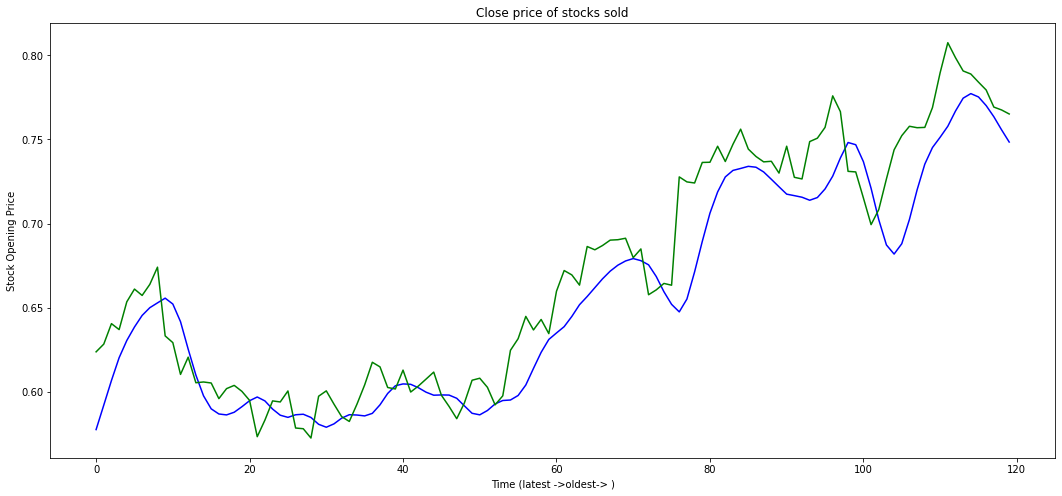

In [29]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'blue')
plt.plot(Y_test, color='green')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()